In [3]:
from keras.models import Sequential # sequencia dos layers
from keras.layers import Dense, Dropout, LSTM #
from sklearn.preprocessing import MinMaxScaler # transformar a escala para 0 e 1 e facilitar o processamento do gradiente
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
base = pd.read_csv('petr4_treinamento.csv') # ler a base de dados
base = base.dropna() # dropando na
base_treinamento = base.iloc[:, 1:2].values # acessando a coluna de treinamento
base_valor_maximo = base.iloc[:, 2:3].values # acessando a coluna valor maximo

In [6]:
normalizador = MinMaxScaler(feature_range=(0,1)) # redefinindo a escala para valores entre 0 e 1
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento) # redefinindo a base treinamento
base_valor_maximo_normalizada = normalizador.fit_transform(base_valor_maximo) # redefinindo a base valor maximo

In [7]:
previsores = []
preco_real1 = []
preco_real2 = []
for i in range(90, 1242): # coletando apenas os 1152 valores
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real1.append(base_treinamento_normalizada[i, 0]) # coletando de treinamento
    preco_real2.append(base_valor_maximo_normalizada[i, 0]) # coletando valor maximo
previsores, preco_real1, preco_real2 = np.array(previsores), np.array(preco_real1), np.array(preco_real2)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [17]:
preco_real = np.column_stack((preco_real1, preco_real2))
print(preco_real.shape) # base com os 1152 valores

(1152, 2)


In [ ]:
regressor = Sequential() # criando um modelo sequencial
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1))) # Modelo Memória de Longo e Curto Prazo de 100 neuronios utilizando os valores de treinamento
# retornando a sequência completa de saídas para cada passo de tempo na sequência de entrada
regressor.add(Dropout(0.3)) # tirar as arestas para otimizar

regressor.add(LSTM(units = 50, return_sequences = True)) # Modelo Memória de Longo e Curto Prazo de 100 neuronios utilizando neuronios anteriores, dessa vez criando 50 neuronios
# retornando a sequência completa de saídas para cada passo de tempo na sequência de entrada
regressor.add(Dropout(0.3)) # tirar as arestas para otimizar

regressor.add(LSTM(units = 50, return_sequences = True))  # Modelo Memória de Longo e Curto Prazo de 100 neuronios utilizando neuronios anteriores, dessa vez criando 50 neuronios
# retornando a sequência completa de saídas para cada passo de tempo na sequência de entrada
regressor.add(Dropout(0.3)) # tirar as arestas para otimizar

regressor.add(LSTM(units = 50))  # Modelo Memória de Longo e Curto Prazo de 100 neuronios utilizando neuronios anteriores, dessa vez criando 50 neuronios
regressor.add(Dropout(0.3)) # tirar as arestas para otimizar

regressor.add(Dense(units = 2, activation = 'linear')) # utilizar linear, com 2 neuronios para a camada densa
# com  uma função de ativação linear, ou seja, a saída da camada será uma combinação linear das entradas.
# regressor.add(Dense(units = 2, activation = 'relu'))


regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error']) # calculando as métricas de desempenho utilizando o erro quadrático médio
regressor.fit(previsores, preco_real, epochs = 5, batch_size = 32) # verificando o ajuste do modelo

Epoch 1/5
36/36 [==============================] - 18s 290ms/step - loss: 0.0366 - mean_absolute_error: 0.1392
Epoch 2/5
36/36 [==============================] - 6s 168ms/step - loss: 0.0167 - mean_absolute_error: 0.1003
Epoch 3/5
36/36 [==============================] - 8s 216ms/step - loss: 0.0148 - mean_absolute_error: 0.0943
Epoch 4/5
36/36 [==============================] - 6s 175ms/step - loss: 0.0123 - mean_absolute_error: 0.0854
Epoch 5/5
36/36 [==============================] - 10s 269ms/step - loss: 0.0111 - mean_absolute_error: 0.0806


In [18]:
base_teste = pd.read_csv('petr4_teste.csv') # lendo a base teste
preco_real_teste = base_teste.iloc[:, 1:2].values # coletando os valores da base teste

In [19]:
base_teste = pd.read_csv('petr4_teste.csv') # lendo a base teste
preco_real_open = base_teste.iloc[:, 1:2].values # coletando os valores da base teste
preco_real_high = base_teste.iloc[:, 2:3].values # coletando os valores da base teste


In [20]:
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas) # transformando as bases

In [21]:
X_teste = []
for i in range(90, 112): # coletando 22 valores para o teste
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [ ]:
previsoes = regressor.predict(X_teste) # realizando as previsoes
previsoes = normalizador.inverse_transform(previsoes) # normalizando as previsoes

1/1 [==============================] - 2s 2s/step


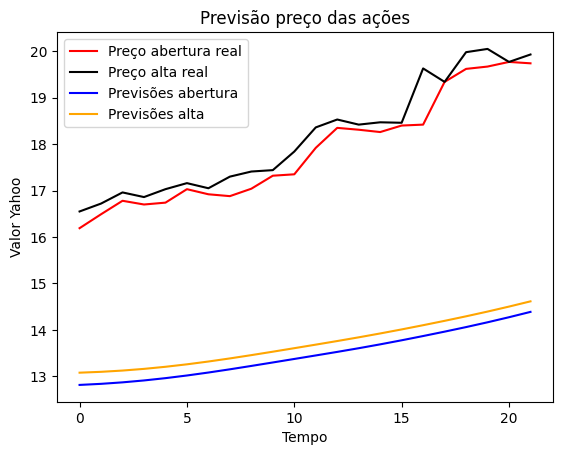

In [ ]:
plt.plot(preco_real_open, color = 'red', label = 'Preço abertura real')
plt.plot(preco_real_high, color = 'black', label = 'Preço alta real')

plt.plot(previsoes[:, 0], color = 'blue', label = 'Previsões abertura')
plt.plot(previsoes[:, 1], color = 'orange', label = 'Previsões alta')

plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()